In [62]:
import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import h5py

In [63]:
class LUDB(Dataset):
    def __init__(self, hdf5_path = 'ludb.h5', 
                 ecg_col = 'tracings', output_col = 'annotations', id_col = 'exam_id', ):
        self.hdf5_file = h5py.File(hdf5_path, 'r')

        self.ecg_col = ecg_col
        self.output_col = output_col
        self.id_col = id_col
    
    def __len__(self):
        return len(self.hdf5_file[self.ecg_col])
    
    def __getitem__(self, idx):
        return {'x': self.hdf5_file[self.ecg_col][idx],
                'y': self.hdf5_file[self.output_col][idx], 
                'exam_id': self.hdf5_file[self.id_col][idx], }

In [148]:
class LUDB(Dataset):
    def __init__(self, hdf5_path = 'ludb.h5', 
                 ecg_col = 'tracings', output_col = 'annotations', id_col = 'exam_id', ):
        self.hdf5_file = h5py.File(hdf5_path, 'r')

        self.ecg_col = ecg_col
        self.output_col = output_col
        self.id_col = id_col
    
    def __len__(self):
        return 12 * len(self.hdf5_file[self.ecg_col])
    
    def __getitem__(self, idx):
        return {'x': self.hdf5_file[self.ecg_col][idx//12, idx%12],
                'y': self.hdf5_file[self.output_col][idx//12, idx%12], 
                'exam_id': self.hdf5_file[self.id_col][idx//12], }

In [149]:
import wfdb
#read ludb ecgs
LEADS = ['avf', 'avl', 'avr', 'i', 'ii', 'iii', 'v1', 'v2', 'v3', 'v4', 'v5', 'v6']
DATA_FOLDER = 'physionet.org/files/ludb/1.0.1/data/'

In [150]:
ds = LUDB()
loader = DataLoader(ds, batch_size = 16, shuffle = True, num_workers = 0)

In [151]:
for batch in (loader):
    break
batch['exam_id'], batch['x'].shape, batch['y'].shape, batch['x'], batch['y']

(tensor([113,  15,  66, 113, 145, 164, 123, 149,  22, 125,  41,  91,   1,  86,
          55, 121], dtype=torch.int32),
 torch.Size([16, 5000]),
 torch.Size([16, 3, 5000]),
 tensor([[ 0.2000,  0.2000,  0.2000,  ...,  0.1403,  0.1417,  0.0993],
         [-0.1444, -0.1408, -0.1373,  ...,  0.0789,  0.0718,  0.0359],
         [-0.0631, -0.0399, -0.0724,  ..., -0.0121, -0.0167,  0.0019],
         ...,
         [ 0.0653,  0.0669,  0.0684,  ...,  0.1444,  0.1854,  0.1392],
         [ 0.2582,  0.2623,  0.2677,  ..., -0.0448, -0.0592, -0.0300],
         [ 0.5273,  0.5321,  0.5368,  ...,  0.0540,  0.1770,  0.3143]],
        dtype=torch.float64),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 

In [178]:
import seaborn as sns
sns.set(style='darkgrid')
sns.set(palette='colorblind')
def plot_ecg_with_segmentation(ecg, segmentation):
    """
    Plot the ECG signal with its segmentation overlayed in timesteps.
    
    Parameters:
    - ecg: 1D array of ECG signal (shape: 5000).
    - segmentation: 2D array of binary segmentation masks (shape: 3, 5000).
    """
    #transform to numpy
    ecg = ecg.numpy()
    segmentation = segmentation.numpy()
    timesteps = np.arange(ecg.shape[0])
    
    # Define colors for each wave
    colors = ['blue', 'green', 'red']
    labels = ['QRS-complex', 'P-wave', 'T-wave']

    plt.figure(figsize=(15, 6))
    
    # Plot the ECG signal
    plt.plot(timesteps, ecg, label='ECG Signal', color='black', linewidth=1.5)

    # Overlay the segmentation
    for i in range(segmentation.shape[0]):
        mask = segmentation[i].astype(bool)
        plt.fill_between(timesteps, ecg.min(), ecg.max(), where=mask, color=colors[i], alpha=0.3, label=f'{labels[i]}')

    # Aesthetics
    plt.title('ECG with Segmentation')
    plt.xlabel('Timestep')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

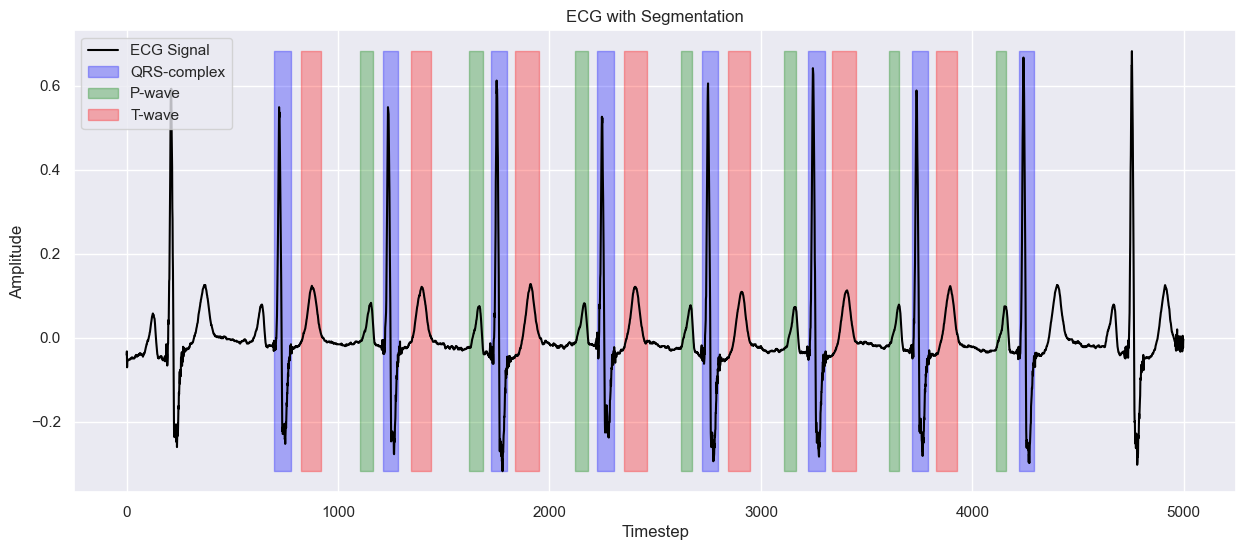

In [179]:
plot_ecg_with_segmentation(batch['x'][2], batch['y'][2])

In [145]:
from unet import UNet
model = UNet(n_channels=12, n_classes=3, bilinear=False)
model(batch['x'][0].unsqueeze(0).float()).shape

torch.Size([1, 3, 5000])

In [182]:
#split ds in train, val, test
from torch.utils.data import random_split
train_size = int(0.8 * len(ds))
val_size = int(0.1 * len(ds))
test_size = len(ds) - train_size - val_size
train_ds, val_ds, test_ds = random_split(ds, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size = 16, shuffle = True, num_workers = 0)
val_loader = DataLoader(val_ds, batch_size = 16, shuffle = True, num_workers = 0)
test_loader = DataLoader(test_ds, batch_size = 16, shuffle = False, num_workers = 0)

In [189]:
#train the model
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=1, n_classes=3, bilinear=False).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
intra_train_loss = []
total_train_loss = []
intra_val_loss = []
total_val_loss = []
model.train()
for epoch in tqdm(range(15)):
    model.train()
    for i, batch in enumerate(train_loader):
        x, y, exam_id = batch['x'].float().to(device), batch['y'].float().to(device), batch['exam_id']
        x = x.to(device).unsqueeze(1)
        y = y.to(device)
        
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        intra_loss.append(loss.item())

    total_loss.append(loss.item())

    #validation
    model.eval()
    for i, batch in enumerate(val_loader):
        x, y, exam_id = batch['x'].float().to(device), batch['y'].float().to(device), batch['exam_id']
        x = x.to(device).unsqueeze(1)
        y = y.to(device)
        
        output = model(x)
        loss = criterion(output, y)
        intra_val_loss.append(loss.item())

    total_val_loss.append(loss.item())

    print(f'Epoch {epoch} - Train Loss: {total_train_loss[-1]} - Val Loss: {total_val_loss[-1]}')

#plot losses
plt.plot(total_train_loss, label='Train Loss')
plt.plot(total_val_loss, label='Val Loss')
plt.legend()
plt.show()



  0%|          | 0/15 [29:30<?, ?it/s]


IndexError: list index out of range

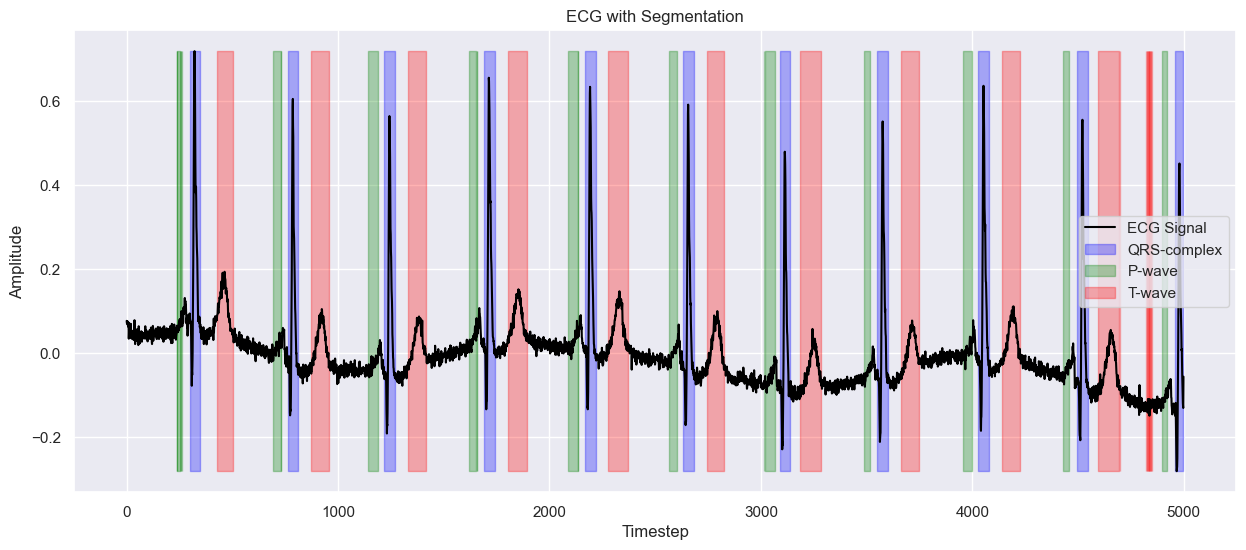

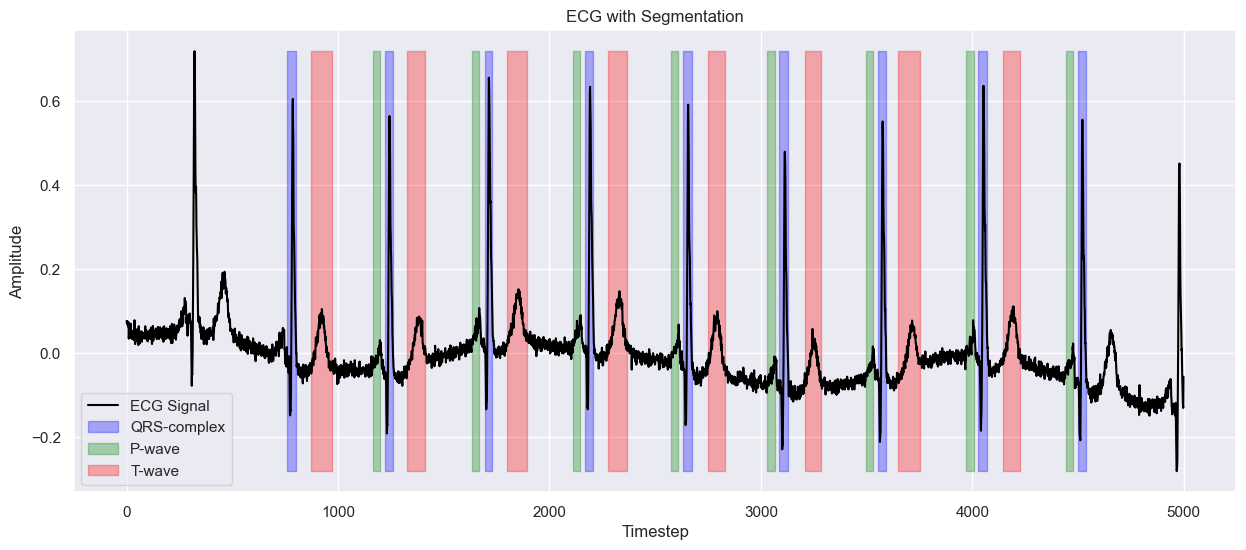

In [193]:
#test the model on a sample
model.eval()
for batch in (test_loader):
    break
output = model(batch['x'].unsqueeze(1).float().to(device))
#plot the output with a threshold to be binary
plot_ecg_with_segmentation(batch['x'][0], (output[0].sigmoid() > 0.5).float())
#plot the true y 
plot_ecg_with_segmentation(batch['x'][0], batch['y'][0])

torch.Size([16, 3, 5000])

In [169]:
train_ds[0]['x']

array([0.01933086, 0.01933086, 0.01933086, ..., 0.09033457, 0.0330855 ,
       0.01412639])